In [2]:
import itertools
import json
import os
import random
from itertools import chain, combinations, product
from pathlib import Path
from typing import Any, Dict, List, Optional

from vizard.models.estimators.manual import (
    InvitationLetterSenderRelation,
    TravelHistoryRegion,
)

mandatory = ["sex"]
FEATURE_VALUES: Dict[str, List[Any]] = {
    "sex": ["male", "female"],
    "education_field_of_study": ["master", "phd", "unedu"],
    "occupation_title1": ["manager", "specialist", "employee"],
    "refused_entry_or_deport": [True, False],
    "date_of_birth": list(range(20, 61, 10)),
    "marriage_period": list(range(0, 31, 10)),
    "occupation_period": list(range(0, 31, 10)),
    "applicant_marital_status": [5, 7],
    "child_accompany": list(range(5)),
    "parent_accompany": list(range(3)),
    "spouse_accompany": list(range(2)),
    "sibling_accompany": list(range(3)),
    "child_count": list(range(5)),
    "invitation_letter": list(InvitationLetterSenderRelation._value2member_map_.keys()),
    "travel_history": list(TravelHistoryRegion._value2member_map_.keys()),
}


class SampleGenerator:
    """Generates samples using predefined feature names and values.

    Attributes:
        feature_values (Dict[str, List[Any]]): Dictionary of feature values.
        mandatory_features (List(str|int)): list of mandatory features
    Note:
        This class helps generate artificial samples to test our trained model.
        It utilizes predefined features and their possible values to create mock
        data for analysis.
    """

    def __init__(
        self,
        feature_values: Dict[str, List[Any]],
        mandatory_features: Optional[list[str]] = None,
    ):
        self.feature_values = feature_values
        self.feature_names = list(self.feature_values.keys())
        if mandatory_features is None:
            self.mandatory_features = []
        else:
            self.mandatory_features = mandatory_features

    def _subsets_with_only_n_items(
        self,
        n: int,
        iterable: Optional[List[str | int]] = None,
    ) -> List[List[str | int]]:
        """create all subsets with size of n

        Args:
            n (int): size of subsets that we want to create
            iterable (Optional[List[str  |  int]], optional): _description_. Defaults to None.

        Returns:
            List[List[str | int]]: a list of all subsets with size of n
        """
        if iterable == None:
            iterable = self.feature_names
        return list(combinations(iterable, n))

    def _powerset(self, iterable=None) -> List[List[str | int]]:
        """create a power-set (all possible subsets) from our list
        Args:
            iterable (List[str]): given list of all feature_names to create subsets
        Returns:
            List[List[str]]: a power-set of given feature_names
        """
        if iterable == None:
            iterable = self.feature_names
        powerset = list(
            chain.from_iterable(
                self._subsets_with_only_n_items(n, iterable)
                for n in range(0, len(iterable) + 1)
            )
        )
        return powerset

    def _powerset_with_mandatory_features(
        self, mandatory_features: List[str | int]
    ) -> List[List[str]]:
        """sometimes we need some features as mandatory this function keep those features in all of the subsets
        Args:
            mandatory_features (Any, optional): list of mandatory features
        Returns:
            List[List[str]]: a list of all possible subsets that all of them have our mandatory features
        """
        iterable = self.feature_names
        if mandatory_features == None:
            mandatory_features = self.mandatory_features
        list_without_mandatory_features = [
            features for features in iterable if features not in mandatory_features
        ]  # remove mandatory items from list
        powerset = self._powerset(list_without_mandatory_features)
        customize_powerset = []  # all subset has mandatory items if mandatory is given
        for single_tuple in powerset:
            customize_powerset.append(list(single_tuple))  # change tuples to list

        for subset in customize_powerset:
            subset.extend(mandatory_features)  # add mandatory_features to all subsets

        return customize_powerset

    def _subsets_with_only_n_items_and_mandatory_features(
        self, only, mandatory_features: List[str | int]
    ) -> List[List[str | int]]:
        feature_names = self.feature_names
        list_without_mandatory_features = [
            features for features in feature_names if features not in mandatory_features
        ]  # remove mandatory items from list
        size_of_subsets_list_without_mandatory_features = only - len(mandatory_features)
        if size_of_subsets_list_without_mandatory_features < 0:
            print("error")  # TODO: check if it works well
        else:
            subsets_list_without_mandatory_features = self._subsets_with_only_n_items(
                size_of_subsets_list_without_mandatory_features,
                list_without_mandatory_features,
            )
            customize_subsets_list = []
            for single_tuple in subsets_list_without_mandatory_features:
                customize_subsets_list.append(
                    list(single_tuple)
                )  # change tuples to list

            for subset in customize_subsets_list:
                subset.extend(
                    mandatory_features
                )  # add mandatory_features to all subsets
            return customize_subsets_list

    def sample_maker(
        self,
        mandatory_features: Optional[List[str | int]] = None,
        only: Optional[int] = None,
    ) -> List[Dict[str, Any]]:
        """Creates all possible samples or a subset of size ``only`` of that

        Args:
            mandatory_features (Optional[List[str | int]], optional): list of mandatory features
            only (Optional[int], optional): if it is given it will create  only samples that
            their size is *n* (it must be between number of mandatory features and number of all features)
        Returns:
            List[Dict[str, Any]]: a list of dictionaries each dict is an acceptable synthesized sample
        """

        if mandatory_features is None:
            mandatory_features = self.mandatory_features
        feature_values = self.feature_values
        feature_names = self.feature_names

        if only is not None:
            if mandatory_features == []:  # if no mandatory features
                subsets_list = self._subsets_with_only_n_items(only, feature_names)
            else:
                subsets_list = self._subsets_with_only_n_items_and_mandatory_features(
                    only, mandatory_features
                )
        else:
            if mandatory_features == []:  # if no mandatory features
                subsets_list = self._powerset(
                    self.feature_names
                )  # all possible subsets
            else:
                subsets_list = self._powerset_with_mandatory_features(
                    mandatory_features
                )  # all possible subsets with mandatory features

        samples = []
        while subsets_list:
            subset = subsets_list.pop()
            sub_dict = self._sub_dict_with_keys(
                subset, feature_values
            )  # dict with only keys that are in our sub list
            samples.extend(self._product_generator(sub_dict))
        return samples

    @staticmethod
    def _product_generator(
        dictionary: Dict[str, List[Any]]
    ) -> List[Dict[str, List[Any]]]:
        """it gets a dictionary of acceptable values then create product of them

        Args:
            dictionary (Dict[str, List[Any]]): a dictionary of all acceptable values for each feature
        Returns:
            List[Dict[str, List[Any]]]: product from possible values that their feature is on given list
        """
        keys = list(dictionary.keys())  # Convert keys to a list
        value_lists = [dictionary[key] for key in keys]

        # Generate all possible combinations of values
        all_combinations = list(product(*value_lists))

        # Create dictionaries for each combination
        result = []
        for combination in all_combinations:
            sample_dict = {keys[i]: combination[i] for i in range(len(keys))}
            result.append(sample_dict)

        return result

    def _sub_dict_with_keys(
        self, input_list: List[str], input_dict: Dict[str, List[Any]]
    ) -> Dict[str, List[Any]]:
        """take the whole dict and returns sub dict with only items that their key is on our list

        Args:
            input_list (List[str]): list of wanted features to including them from our given dict
            input_dict (Dict[str, List[[Any]]]): a dictionary of all acceptable values for each feature
        Returns:
            Dict[str, List[[Any]]]: Dict of wanted features and their acceptable values
        Note:
            this is needed for _product_generator
        """

        input_dict = self.feature_values
        return {key: input_dict[key] for key in input_list if key in input_dict}

    def save_to_json(
        self,
        mode: float,
        n: Optional[int] = None,
        batch_size: Optional[int] = None,
    ):
        """save generated samples to a json file

        Args:
            mode (float): if mode is between 0 and 1 it will create random samples (x percentage of all samples), use 1 to create all possible samples
            n (int, Optional): if it is given it will create  only samples that their size is n (it most be between number of mandatory features and number of all features)
            batch_size (Optional): for bigger files we create batches

        """
        all = False

        if mode == 1:
            all = True
        elif 0 <= mode < 1:
            percentage = mode
        else:
            print("mode must be between 0 and 1")
            return

        only = n
        mandatory_features = self.mandatory_features

        if only is None:
            range_min = len(mandatory_features)
            range_max = len(FEATURE_VALUES)
        else:
            if len(mandatory_features) > only or only > len(self.feature_names):
                print(
                    "given n (size of subsets) most be between number of mandatory features and number of all features"
                )
                return
            range_min = range_max = only

        # Get the directory of the currently running script
        # current_script_directory = os.path.dirname(os.path.realpath(__file__))
        current_script_directory = os.getcwd()

        # Create a new directory named 'ddx' in the current script's directory
        directory = os.path.join(current_script_directory, "synthetic_samples/")

        # Create the directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        if all:
            for i in range(range_min, range_max + 1):  # TODO: progress bar?
                samples = self.sample_maker(mandatory_features, i)
                file_path = f"{directory}sample_with_size_{i}.json"
                with open(file_path, "w") as f:
                    json.dump(samples, f, indent=4)
                print(
                    f"saving all subset size {i} samples to synthetic_samples/sample_with_size_{i}.json | size = {len(samples)}"
                )
            print(
                "completed",
                range_max - range_min + 1,
                "items",
            )
            return samples

        else:  # if all is False we create random samples
            size_dict = self._size_of_products()
            random_directory = os.path.join(
                directory, f"random_percentage_{percentage}/"
            )
            os.makedirs(random_directory, exist_ok=True)
            for i in range(range_min, range_max + 1):
                random_size = int(size_dict[f"size_{i}"] * percentage) + 1
                samples = self._randomy(i, random_size)
                file_path = (
                    f"{random_directory}random_sample_with_subset_size_of_{i}.json"
                )
                with open(file_path, "w") as f:
                    json.dump(samples, f, indent=4)
                print(
                    f"saving subset size {i}".ljust(21),
                    f"random samples to synthetic_samples/random_percentage_{percentage}/random_sample_with_subset_size_of_{i}.json".ljust(
                        102
                    ),
                    f"| size = {random_size:,}",
                )
                return samples

        # TODO: batching for bigger files
        # if batch_size is None:
        #     file_path = f"{directory}sample{n}.json"
        #     with open(file_path, "w") as f:
        #         json.dump(self.sample_maker(), f, indent=4)
        # else:
        #     pass

    def _randomy(self, only: int, numbers: int) -> List[Dict[str, Any]]:
        """generate random samples for our instance

        Args:
            only (int): size of subsets that we want to create
            numbers (int): number of random samples that we want to create

        Returns:
            List[Dict[str, Any]]: a list of dictionaries each dict is an acceptable synthetic sample
        Note:

        """
        n = only

        samples = []
        if self.mandatory_features == []:
            for i in range(numbers):
                sample = {}
                selected_features = random.sample(self.feature_names, n)
                for feature in selected_features:
                    sample[feature] = random.choice(self.feature_values[feature])
                samples.append(sample)
        else:
            for i in range(numbers):
                sample = {}
                features_without_mandatory = [
                    features
                    for features in self.feature_names
                    if features not in self.mandatory_features
                ]
                selected_features = random.sample(
                    features_without_mandatory, n - len(self.mandatory_features)
                )
                for feature in selected_features:
                    sample[feature] = random.choice(self.feature_values[feature])
                for feature in self.mandatory_features:
                    sample[feature] = random.choice(self.feature_values[feature])
                samples.append(sample)

        return samples

    def _size_of_products(self) -> Dict[str, int]:
        """give us the size of all possible samples for each subset size

        Raises:
            Exception: if mandatory feature is not in our feature_values

        Returns:
            Dict[str, int]: a dictionary of sizes for each subset size
        """
        features_values = self.feature_values
        mandatory = self.mandatory_features

        mandatory_multiplier = 1
        if mandatory:
            for item in mandatory:
                if item in features_values:
                    mandatory_multiplier *= len(features_values[item])
                else:
                    raise Exception(f"mandatory feature {item} not in features")

        features_values_without_mandatory = {
            key: features_values[key] for key in features_values if key not in mandatory
        }

        features_possible_choices = features_values_without_mandatory.values()
        size_dict = {}
        for i in range(len(features_possible_choices) + 1):
            size = 0
            for subset in itertools.combinations(features_possible_choices, i):
                c = 1
                for item in subset:
                    c *= len(item)
                size += c

            size *= mandatory_multiplier  # for mandatory features
            size_dict[f"size_{i+len(mandatory)}"] = size

        return size_dict


####################################
import logging
import pickle
import shutil
from pathlib import Path

import dvc.api
import mlflow
import numpy as np
import pandas as pd

from vizard.data import functional, preprocessor
from vizard.data.constant import OccupationTitle
from vizard.models import preprocessors, trainers
from vizard.models.estimators.manual import (
    InvitationLetterParameterBuilder,
    InvitationLetterSenderRelation,
    TravelHistoryParameterBuilder,
    TravelHistoryRegion,
)
from vizard.utils import loggers
from vizard.version import VERSION as VIZARD_VERSION
from vizard.xai import FlamlTreeExplainer

# run mlflow tracking server
mlflow.set_tracking_uri(f"http://0.0.0.0:5000")

# data versioning config
PATH = "raw-dataset/all-dev.pkl"  # path to source data, e.g. data.pkl file
REPO = "../../visaland-visa-form-utility"
VERSION = "v3.0.0-dev"  # use the latest EDA version (i.e. `vx.x.x-dev`)
# get url data from DVC data storage
data_url = dvc.api.get_url(path=PATH, repo=REPO, rev=VERSION)
data = pd.read_pickle(data_url).drop(columns=["VisaResult"], inplace=False)

# DVC: helper - (for more info see the API that uses these files)
# data file for converting country names to continuous score in "economical" sense
HELPER_PATH_GDP = "raw-dataset/API_NY.GDP.PCAP.CD_DS2_en_xml_v2_4004943.pkl"
HELPER_VERSION_GDP = "v0.1.0-field-GDP"  # use latest using `git tag`
# data file for converting country names to continuous score in "all" possible senses
HELPER_PATH_OVERALL = "raw-dataset/databank-2015-2019.pkl"
HELPER_VERSION_OVERALL = "v0.1.0-field"  # use latest using `git tag`
# gather these for MLFlow track
all_helper_data_info = {
    HELPER_PATH_GDP: HELPER_VERSION_GDP,
    HELPER_PATH_OVERALL: HELPER_VERSION_OVERALL,
}
# data file for converting country names to continuous score in "economical" sense
worldbank_gdp_dataframe = pd.read_pickle(
    dvc.api.get_url(path=HELPER_PATH_GDP, repo=REPO, rev=HELPER_VERSION_GDP)
)
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(
    dataframe=worldbank_gdp_dataframe
)
# data file for converting country names to continuous score in "all" possible senses
worldbank_overall_dataframe = pd.read_pickle(
    dvc.api.get_url(path=HELPER_PATH_OVERALL, repo=REPO, rev=HELPER_VERSION_OVERALL)
)
edu_country_score_preprocessor = (
    preprocessor.EducationCountryScoreDataframePreprocessor(
        dataframe=worldbank_overall_dataframe
    )
)

# configure logging
VERBOSE = logging.DEBUG
MLFLOW_ARTIFACTS_BASE_PATH: Path = Path("artifacts")
if MLFLOW_ARTIFACTS_BASE_PATH.exists():
    shutil.rmtree(MLFLOW_ARTIFACTS_BASE_PATH)
__libs = ["snorkel", "vizard", "flaml"]
logger = loggers.Logger(
    name=__name__,
    level=VERBOSE,
    mlflow_artifacts_base_path=MLFLOW_ARTIFACTS_BASE_PATH,
    libs=__libs,
)

# log experiment configs
MLFLOW_EXPERIMENT_NAME = f"{VIZARD_VERSION}"
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.start_run()

logger.info(f"MLflow experiment name: {MLFLOW_EXPERIMENT_NAME}")
logger.info(f"MLflow experiment id: {mlflow.active_run().info.run_id}")

# get mlflow run id for extracting artifacts of the desired run
MLFLOW_RUN_ID = "426deb77881b4d719c2c0d18ce7c36db"
mlflow.log_param("mlflow-trained-run-id", MLFLOW_RUN_ID)

# load fitted preprocessing models
X_CT_NAME = "train_sklearn_column_transfer.pkl"
x_ct_path = mlflow.artifacts.download_artifacts(
    run_id=MLFLOW_RUN_ID,
    artifact_path=f"0/models/{X_CT_NAME}",
    dst_path=f"api/artifacts",
)
with open(x_ct_path, "rb") as f:
    x_ct: preprocessors.ColumnTransformer = pickle.load(f)

# load fitted FLAML AutoML model for prediction
FLAML_AUTOML_NAME = "flaml_automl.pkl"
flaml_automl_path = mlflow.artifacts.download_artifacts(
    run_id=MLFLOW_RUN_ID,
    artifact_path=f"0/models/{FLAML_AUTOML_NAME}",
    dst_path=f"api/artifacts",
)
with open(flaml_automl_path, "rb") as f:
    flaml_automl: trainers.AutoML = pickle.load(f)

feature_names = preprocessors.get_transformed_feature_names(
    column_transformer=x_ct,
    original_columns_names=data.columns.values,
)

# SHAP tree explainer #56
flaml_tree_explainer = FlamlTreeExplainer(
    flaml_model=flaml_automl, feature_names=feature_names, data=None
)

# Create instances of manual parameter insertion
invitation_letter_param = InvitationLetterParameterBuilder()
# Create instances of manual parameter insertion
travel_history_param = TravelHistoryParameterBuilder()
MANUAL_PARAM_NAMES_ANSWERED_DICT: Dict[str, bool] = {
    invitation_letter_param.name: False,
    travel_history_param.name: False,
}


def preprocess(features_dict: Dict[str, Any], provided_variables: List[str]):
    # Create instances of manual parameter insertion
    invitation_letter_param = InvitationLetterParameterBuilder()
    # Create instances of manual parameter insertion
    travel_history_param = TravelHistoryParameterBuilder()
    MANUAL_PARAM_NAMES_ANSWERED_DICT: Dict[str, bool] = {
        invitation_letter_param.name: False,
        travel_history_param.name: False,
    }

    # reset manual variable responses
    for k, _ in MANUAL_PARAM_NAMES_ANSWERED_DICT.items():
        MANUAL_PARAM_NAMES_ANSWERED_DICT[k] = False

    # if manual param is answered, make its value True
    for param in provided_variables:
        if param in MANUAL_PARAM_NAMES_ANSWERED_DICT.keys():
            MANUAL_PARAM_NAMES_ANSWERED_DICT[param] = True

    # set response for invitation letter
    invitation_letter_param.set_response(
        response=InvitationLetterSenderRelation(features_dict["invitation_letter"]),
        raw=True,
    )
    # remove invitation letter so preprocessing, transformation, etc works just like before
    if invitation_letter_param.name in features_dict:
        del features_dict[invitation_letter_param.name]
    if invitation_letter_param.name in provided_variables:
        provided_variables.remove(invitation_letter_param.name)

    # set response for travel history
    travel_history_param.set_response(
        response=TravelHistoryRegion(features_dict["travel_history"]),
        raw=True,
    )
    # remove invitation letter so preprocessing, transformation, etc works just like before
    if travel_history_param.name in features_dict:
        del features_dict[travel_history_param.name]
    if travel_history_param.name in provided_variables:
        provided_variables.remove(travel_history_param.name)

    return features_dict, invitation_letter_param, travel_history_param


def predict(
    features_dict_list: List[Dict[str, Any]],
    invitation_letter_param_list: List[InvitationLetterParameterBuilder],
    travel_history_param_list: List[TravelHistoryParameterBuilder],
) -> float:
    features_list_list: List[List[float]] = []
    for features_dict in features_dict_list:
        # convert api data to model data
        features_list = list(features_dict.values())
        features_list_list.append(features_list)
    # convert to dataframe
    x_test = pd.DataFrame(data=features_list_list, columns=data.columns)
    x_test = x_test.astype(data.dtypes)
    x_test = x_test.to_numpy()
    # preprocess test data
    xt_test = x_ct.transform(x_test)
    # predict
    y_pred = flaml_automl.predict_proba(xt_test)
    label = np.argmax(y_pred, axis=1)
    y_pred = y_pred[:, label.reshape(1, -1)][:, :, 0]
    result = np.where([label.flatten() == 1], y_pred.flatten(), 1 - y_pred.flatten())
    result = result.reshape(-1, 1)

    for i in range(len(result)):
        # apply invitation letter modification given the response
        result[i] = invitation_letter_param_list[i].probability_modifier(
            probability=result[i].item()
        )
        # apply travel history modification given the response
        result[i] = travel_history_param_list[i].probability_modifier(
            probability=result[i].item()
        )

    return result, xt_test


def batched_inference(mode, only):
    batch_size: int = 1e14

    samples_list: List[np.ndarray] = []
    results_list: List[np.ndarray] = []

    sampler = SampleGenerator(
        feature_values=FEATURE_VALUES, mandatory_features=mandatory
    )
    samples = sampler.save_to_json(mode=mode, n=only)

    # process all samples if smaller than batch size
    do_all_samples: bool = True if len(samples) < batch_size else False
    batch_size = len(samples) if do_all_samples else batch_size

    i = 0
    travel_history_param_list: List[TravelHistoryParameterBuilder] = []
    invitation_letter_param_list: List[InvitationLetterParameterBuilder] = []
    features_dict_list: List[Dict[str, Any]] = []
    for sample in samples:
        default_feature: Dict[str, Any] = {
            "sex": "string",
            "education_field_of_study": "unedu",
            "occupation_title1": "OTHER",
            "refused_entry_or_deport": False,
            "date_of_birth": 18,
            "marriage_period": 0,
            "occupation_period": 0,
            "applicant_marital_status": "7",
            "child_accompany": 0,
            "parent_accompany": 0,
            "spouse_accompany": 0,
            "sibling_accompany": 0,
            "child_count": 0,
            "invitation_letter": "none",
            "travel_history": "none",
        }
        for f, v in sample.items():
            default_feature[f] = v
        if "sex" in default_feature:
            default_feature["sex"] = (
                default_feature["sex"].lower().capitalize()
            )  # female -> Female, ...

        def __occupation_title_x(value: str) -> str:
            value = value.lower()
            if value == OccupationTitle.OTHER.name.lower():
                value = OccupationTitle.OTHER.name
            return value

        if "occupation_title1" in default_feature:
            default_feature["occupation_title1"] = __occupation_title_x(
                value=default_feature["occupation_title1"]
            )
        # prepare batched tests
        fd, ilp, thp = preprocess(
            features_dict=default_feature,
            provided_variables=list(default_feature.keys()),
        )

        travel_history_param_list.append(ilp)
        invitation_letter_param_list.append(thp)
        features_dict_list.append(fd)

        i += 1
        # prepare the batch and do batched inference
        if i % batch_size == 0:
            batched_result, batched_input = predict(
                features_dict_list=features_dict_list,
                invitation_letter_param_list=invitation_letter_param_list,
                travel_history_param_list=travel_history_param_list,
            )
            results_list.append(batched_result)
            samples_list.append(batched_input)

            # reset the batch
            i = 0
            features_dict_list = []
            invitation_letter_param_list = []
            travel_history_param_list = []

    return results_list, samples_list



/home/nikan/miniforge3/envs/vizard-dev/lib/python3.10/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/nikan/miniforge3/envs/vizard-dev/lib/python3.10/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


[__main__: 12-26 09:30:57] {491} INFO - MLflow experiment name: 0.26.0


[__main__: 12-26 09:30:57] {491} INFO - MLflow experiment name: 0.26.0


[__main__: 12-26 09:30:57] {492} INFO - MLflow experiment id: 3e72380497a64c799c1d6d61e78290cf


[__main__: 12-26 09:30:57] {492} INFO - MLflow experiment id: 3e72380497a64c799c1d6d61e78290cf


In [65]:
# 'size_1':           2
# 'size_2':         122
# 'size_3':        3364
# 'size_4':       55680
# 'size_5':      619100
# 'size_6':     4899052
# 'size_7':    28488336
# 'size_8':   123802616
# 'size_9':   404396578
# 'size_10':  988817386
# 'size_11': 1782782940
# 'size_12': 2299499064
# 'size_13': 2006814960
# 'size_14': 1061164800
# 'size_15':  256608000

mode_only = [
    (1, 2),
    (1, 3),
    (1, 4),
    (1e-1 * 0.5, 5),
    (1e-2, 6),
    (1e-3, 7),
    (1e-4, 8),
    (1e-4, 9),
    (1e-4, 10),
    (1e-5, 11),
    (1e-5, 12),
    (1e-5, 13),
    (1e-5, 14),
    (1e-4, 15),
]

def get_train_data(list_x, list_y):
    batch_size = list_x[0].shape[0]

    if list_y is not None:
        assert len(list_x) == len(list_y)
    print(f"{len(list_x)=}")
    print(f"{batch_size=}")

    x = np.empty(shape=(len(list_x) * list_x[0].shape[0], list_x[0].shape[1]), dtype=np.float32)
    if list_y is not None:
        y = np.empty(shape=(len(list_y) * list_y[0].shape[0], list_y[0].shape[1]), dtype=np.float32)

    for i in range(len(list_x)):
        x[i: (i+1) * batch_size, :] = list_x[i]
    if list_y is not None:
        for i in range(len(list_y)):
            y[i: (i+1) * batch_size, :] = list_y[i]

    print(f"{x.shape=}")
    if list_y is not None:
        print(f"{y.shape=}")
    
    if list_y is not None:
        return x, y
    return x

In [66]:
def train(x, y):
    import time
    import warnings
    from itertools import cycle, islice

    import matplotlib.pyplot as plt
    import numpy as np

    from sklearn import cluster, datasets, mixture
    from sklearn.neighbors import kneighbors_graph
    from sklearn.preprocessing import StandardScaler



    # ============
    # Set up cluster parameters
    # ============
    plt.figure(figsize=(13 * 5, 15))
    # plt.subplots_adjust(
    #     left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
    # )

    plot_num = 1

    default_base = {
        "quantile": 0.3,
        "eps": 0.3,
        "damping": 0.9,
        "preference": -200,
        "n_neighbors": 3,
        "n_clusters": 3,
        "min_samples": 7,
        "xi": 0.05,
        "min_cluster_size": 0.1,
        "allow_single_cluster": True,
        "hdbscan_min_cluster_size": 15,
        "hdbscan_min_samples": 3,
        "random_state": 42,
        "n_jobs": -1
    }

    datasets = [
        (
            (x, y),
            {
            },
        ),
    ]

    for i_dataset, (dataset, algo_params) in enumerate(datasets):
        # update parameters with dataset-specific values
        params = default_base.copy()
        params.update(algo_params)

        X, y = dataset

        # normalize dataset for easier parameter selection
        # X = StandardScaler().fit_transform(X)

        # estimate bandwidth for mean shift
        bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=params["n_neighbors"], include_self=False
        )
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)

        # ============
        # Create cluster objects
        # ============
        ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        two_means = cluster.MiniBatchKMeans(
            n_clusters=params["n_clusters"],
            n_init="auto",
            random_state=params["random_state"],
        )
        ward = cluster.AgglomerativeClustering(
            n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
        )
        spectral = cluster.SpectralClustering(
            n_clusters=params["n_clusters"],
            eigen_solver="arpack",
            affinity="nearest_neighbors",
            random_state=params["random_state"],
        )
        dbscan = cluster.DBSCAN(eps=params["eps"])
        hdbscan = cluster.HDBSCAN(
            min_samples=params["hdbscan_min_samples"],
            min_cluster_size=params["hdbscan_min_cluster_size"],
            allow_single_cluster=params["allow_single_cluster"],
        )
        optics = cluster.OPTICS(
            min_samples=params["min_samples"],
            xi=params["xi"],
            min_cluster_size=params["min_cluster_size"],
        )
        affinity_propagation = cluster.AffinityPropagation(
            damping=params["damping"],
            preference=params["preference"],
            random_state=params["random_state"],
        )
        average_linkage = cluster.AgglomerativeClustering(
            linkage="average",
            metric="cityblock",
            n_clusters=params["n_clusters"],
            connectivity=connectivity,
        )
        birch = cluster.Birch(n_clusters=params["n_clusters"])
        gmm = mixture.GaussianMixture(
            n_components=params["n_clusters"],
            covariance_type="full",
            random_state=params["random_state"],
        )

        clustering_algorithms = (
            ("MiniBatch\nKMeans", two_means),
            ("Affinity\nPropagation", affinity_propagation),
            ("MeanShift", ms),
            ("Spectral\nClustering", spectral),
            ("Ward", ward),
            ("Agglomerative\nClustering", average_linkage),
            ("DBSCAN", dbscan),
            ("HDBSCAN", hdbscan),
            ("OPTICS", optics),
            ("BIRCH", birch),
            ("Gaussian\nMixture", gmm),
        )

        for name, algorithm in clustering_algorithms:
            t0 = time.time()

            # catch warnings related to kneighbors_graph
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    "ignore",
                    message="the number of connected components of the "
                    + "connectivity matrix is [0-9]{1,2}"
                    + " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning,
                )
                warnings.filterwarnings(
                    "ignore",
                    message="Graph is not fully connected, spectral embedding"
                    + " may not work as expected.",
                    category=UserWarning,
                )
                algorithm.fit(X)
                print(f"Training on {name=} finished.")

            t1 = time.time()
            if hasattr(algorithm, "labels_"):
                y_pred = algorithm.labels_.astype(int)
            else:
                y_pred = algorithm.predict(X)

            plt.subplot(len(clustering_algorithms), 1, plot_num)
            if i_dataset == 0:
                plt.title(name, size=18)

            colors = np.array(
                list(
                    islice(
                        cycle(
                            [
                                "#377eb8",
                                "#ff7f00",
                                "#4daf4a",
                                "#f781bf",
                                "#a65628",
                                "#984ea3",
                                "#999999",
                                "#e41a1c",
                                "#dede00",
                            ]
                        ),
                        int(max(y_pred) + 1),
                    )
                )
            )
            # add black color for outliers (if any)
            colors = np.append(colors, ["#000000"])
            plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

            plt.xlim(-2.5, 2.5)
            plt.ylim(-2.5, 2.5)
            plt.xticks(())
            plt.yticks(())
            plt.text(
                0.99,
                0.01,
                ("%.2fs" % (t1 - t0)).lstrip("0"),
                transform=plt.gca().transAxes,
                size=15,
                horizontalalignment="right",
            )
            plot_num += 1

    plt.show()

## Only=2

saving all subset size 2 samples to synthetic_samples/sample_with_size_2.json | size = 122
completed 1 items
len(list_x)=1
batch_size=122
x.shape=(122, 26)
y.shape=(122, 1)
Training on name='MiniBatch\nKMeans' finished.
Training on name='Affinity\nPropagation' finished.
Training on name='MeanShift' finished.
Training on name='Spectral\nClustering' finished.
Training on name='Ward' finished.
Training on name='Agglomerative\nClustering' finished.
Training on name='DBSCAN' finished.
Training on name='HDBSCAN' finished.


divide by zero encountered in divide


Training on name='OPTICS' finished.
Training on name='BIRCH' finished.
Training on name='Gaussian\nMixture' finished.


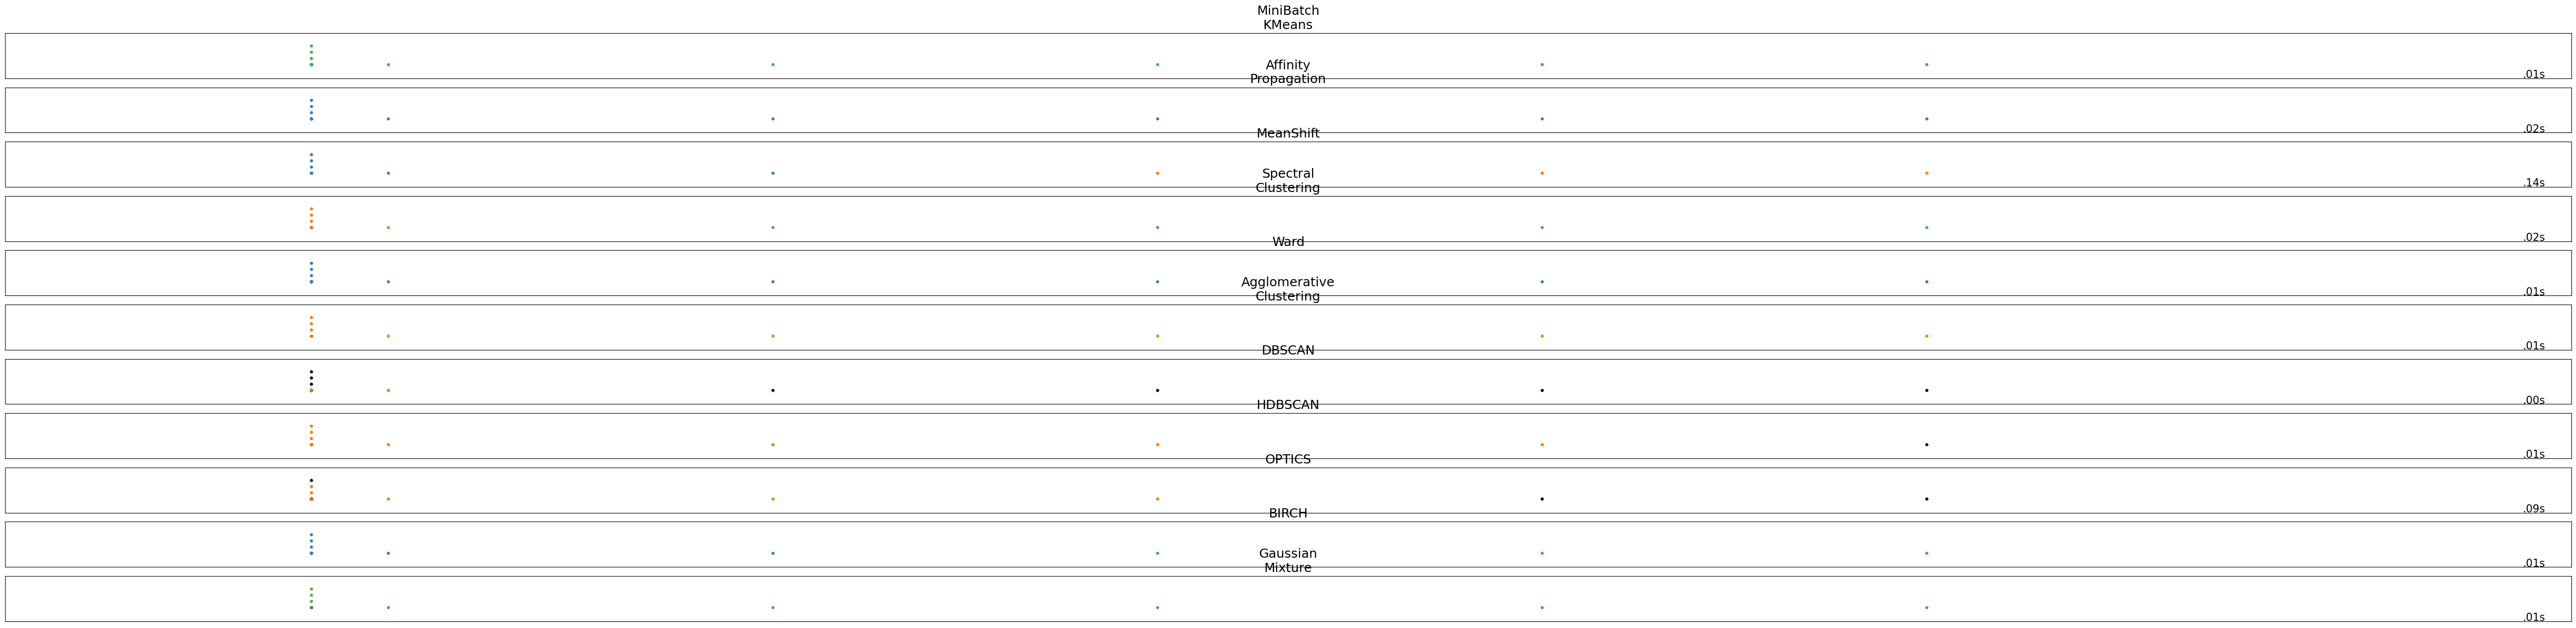

In [64]:
list_y, list_x = batched_inference(*mode_only[0])
x, y = get_train_data(list_x=list_x, list_y=list_y)
train(x, y)
